In [47]:
import jax
from flax import nnx
import jax.numpy as jnp

In [48]:
# Import additional libraries for data loading and training
from datasets import load_dataset, Dataset
import numpy as np
import optax
from tqdm import tqdm
import PIL
import importlib.util

In [49]:
jax.devices()

[CpuDevice(id=0)]

In [50]:
data_dir = "./data"
# Load CIFAR-10 dataset
dataset = load_dataset("uoft-cs/cifar10", cache_dir=data_dir)
dataset = dataset.with_format("jax")
train_data = dataset["train"]
test_data = dataset["test"]
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

print(train_data.features)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Sample shape: {train_data[0]['img'].shape}")

data_dim = train_data[0]["img"].shape[0] * train_data[0]["img"].shape[1] * train_data[0]["img"].shape[2]


{'img': Image(mode=None, decode=True), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}
Train samples: 50000
Test samples: 10000
Sample shape: (32, 32, 3)


In [ ]:
# Training configuration
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5

In [ ]:
from typing import SupportsIndex, TypedDict
import grain.python as grain
import jax.numpy as jnp


seed = 12
val_batch_size = 2 * BATCH_SIZE


def preprocess(image: jnp.ndarray, rng: np.random.Generator) -> jnp.ndarray:
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Flatten the image
    image = image.reshape(-1)
    return image
    
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

train_grain_dataset = grain.MapDataset.source(train_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=BATCH_SIZE)

test_grain_dataset = grain.MapDataset.source(test_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=val_batch_size)

In [53]:
# # Preprocess data: flatten images and normalize
# def preprocess_batch(batch):
#     """Convert images to flattened arrays and normalize to [0, 1]"""
#     images = np.array(batch["image"])
#     # Flatten 28x28 images to 784-dim vectors
#     images = images.reshape(images.shape[0], -1).astype(np.float32) / 255.0
#     return images

# # Create data batches
# def create_batches(data, batch_size=32, shuffle=True):
#     """Generator that yields batches of data"""
#     indices = np.arange(len(data))
#     if shuffle:
#         np.random.shuffle(indices)
    
#     for i in range(0, len(indices), batch_size):
#         batch_indices = indices[i:i + batch_size]
#         batch = data.select(batch_indices)
#         yield preprocess_batch(batch)

In [54]:
# Define loss function
def mse_loss(model, x):
    """Mean squared error reconstruction loss"""
    x_reconstructed = model(x)
    return jnp.mean((x - x_reconstructed) ** 2)

@nnx.jit
def train_step(model, optimizer, x):
    """Single training step"""
    loss, grads = nnx.value_and_grad(mse_loss)(model, x)
    
    # Update with BOTH model and grads
    optimizer.update(grads=grads, model=model) 
    return loss

In [55]:
Encoder = lambda rngs: nnx.Linear(data_dim, 512, rngs=rngs)
Decoder = lambda rngs: nnx.Linear(512, data_dim, rngs=rngs)

class MNISTAutoEncoder(nnx.Module):
    def __init__(self, rngs):
        self.encoder = Encoder(rngs)
        self.decoder = Decoder(rngs)
    
    def __call__(self, x) -> jax.Array:
        return self.decoder(self.encoder(x))
    
    def encode(self, x) -> jax.Array:
        return self.encoder(x)

In [56]:

# Initialize model and optimizer
rngs = nnx.Rngs(0)
model = MNISTAutoEncoder(rngs)
optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)

print("Model initialized")
print(f"Encoder: {model.encoder}")
print(f"Decoder: {model.decoder}")

Model initialized
Encoder: Linear( # Param: 1,573,376 (6.3 MB)
  kernel=Param( # 1,572,864 (6.3 MB)
    value=Array(shape=(3072, 512), dtype=dtype('float32'))
  ),
  bias=Param( # 512 (2.0 KB)
    value=Array(shape=(512,), dtype=dtype('float32'))
  ),
  in_features=3072,
  out_features=512,
  use_bias=True,
  dtype=None,
  param_dtype=float32,
  precision=None,
  kernel_init=<function variance_scaling.<locals>.init at 0x7f99488832e0>,
  bias_init=<function zeros at 0x7f994975d940>,
  dot_general=<function dot_general at 0x7f9949ac9300>,
  promote_dtype=<function promote_dtype at 0x7f9948883380>,
  preferred_element_type=None
)
Decoder: Linear( # Param: 1,575,936 (6.3 MB)
  kernel=Param( # 1,572,864 (6.3 MB)
    value=Array(shape=(512, 3072), dtype=dtype('float32'))
  ),
  bias=Param( # 3,072 (12.3 KB)
    value=Array(shape=(3072,), dtype=dtype('float32'))
  ),
  in_features=512,
  out_features=3072,
  use_bias=True,
  dtype=None,
  param_dtype=float32,
  precision=None,
  kernel_init=<

In [57]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [58]:
total_steps = len(train_data) // BATCH_SIZE
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"


# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_losses = []
    
    # Create progress bar
    with tqdm(
        desc=f"[train] epoch: {epoch}/{NUM_EPOCHS}, ",
        total=total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_grain_dataset:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)
        
    
    avg_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {avg_loss:.4f}")

[train] epoch: 0/10, [0/390] [00:00<?]

[train] epoch: 0/10, [391/?], loss=0.0212 [00:28<00:00]  
/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/.venv/lib64/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/.venv/lib64/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/10 - Average Loss: nan


[train] epoch: 1/10, [391/?], loss=0.0128 [00:28<00:00]  


Epoch 2/10 - Average Loss: nan


[train] epoch: 2/10, [391/?], loss=0.00944 [00:29<00:00]  


Epoch 3/10 - Average Loss: nan


[train] epoch: 3/10, [391/?], loss=0.00772 [00:29<00:00]  


Epoch 4/10 - Average Loss: nan


[train] epoch: 4/10, [391/?], loss=0.00641 [00:29<00:00]  


Epoch 5/10 - Average Loss: nan


[train] epoch: 5/10, [274/390], loss=0.00589 [00:20<00:08]


KeyboardInterrupt: 

In [ ]:
# Evaluate on test set
test_losses = []
for batch_x in test_grain_dataset:
    loss = mse_loss(model, batch_x)
    test_losses.append(float(loss))

avg_test_loss = np.mean(test_losses)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0059


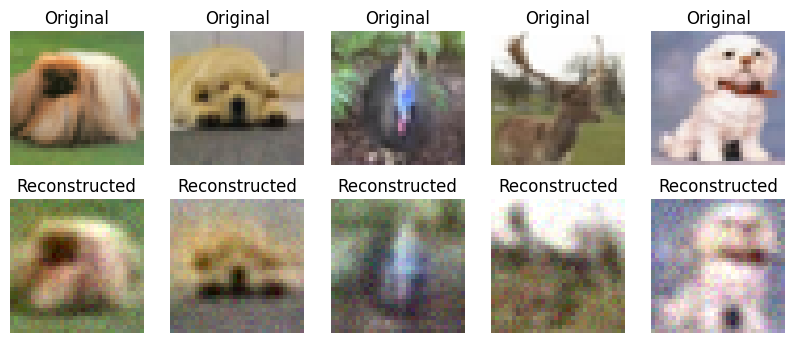

In [ ]:
# Plot some reconstructed images
import matplotlib.pyplot as plt
num_images = 5
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
for i, batch_x in enumerate(test_grain_dataset):
    reconstructed = model(batch_x)
    for j in range(num_images):
        if i * num_images + j >= len(test_grain_dataset):
            break
        # Original image
        axes[0, j].imshow(batch_x[j].reshape(32, 32, 3), cmap='gray')
        axes[0, j].axis('off')
        if i == 0:
            axes[0, j].set_title("Original")
        
        # Reconstructed image
        axes[1, j].imshow(reconstructed[j].reshape(32, 32, 3), cmap='gray')
        axes[1, j].axis('off')
        if i == 0:
            axes[1, j].set_title("Reconstructed")
    break  # Only plot first batch